# Sentiment Classification

- 런타임 -> 런타임 유형변경 -> GPU로 설정!



In [1]:
# check runtime type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
  device = 'cpu'
else:
  print(gpu_info)
  device = 'cuda'

Thu Oct 29 00:16:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     8W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 영화 리뷰 데이터 불러오기

In [2]:
from torchtext import data
import pandas as pd

# from konlpy.tag import Mecab

In [3]:
path = '/content/drive/My Drive/Colab Notebooks/2020-PoscoICT/Data/'

train_df = pd.read_csv(path+'nsmc/ratings_train.txt', sep='\t', encoding='utf-8')
test_df = pd.read_csv(path+'nsmc/ratings_test.txt', sep='\t', encoding='utf-8')
print(train_df.shape, test_df.shape)

# 리뷰 또는 레이블이 비어있는 경우 제거
train_df.dropna(how='any', inplace=True)
test_df.dropna(how='any', inplace=True)
print(train_df.shape, test_df.shape)

train_df.to_csv(path+'nsmc/ratings_train_cleaned.tsv', sep='\t', index=False, encoding='utf-8')
test_df.to_csv(path+'nsmc/ratings_test_cleaned.tsv', sep='\t', index=False, encoding='utf-8')

(150000, 3) (50000, 3)
(149995, 3) (49997, 3)


### TorchText 로 네이버 영화 리뷰 데이터 로드하기

- 텍스트 분류 문제를 풀 때, 유용하게 사용되는 torchtext라는 라이브러리
- 다양한 기능을 제공하고 있으며, documentation도 함께 참고
- 참고자료: http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/

In [5]:
import torch
from torchtext.data import TabularDataset

# 필드 정의하기(전처리 방식 지정)
TEXT = data.Field(# tokenize=Mecab().morphs,	# 토크나이저로는 Mecab 사용.
                  tokenize = lambda x: x.split(),
                  include_lengths=True)
                  # sequential=True,
                  # use_vocab=True, 					# 단어집합을 만든다
                  # lower=True,
                  # batch_first=True,
                  # fix_length=20) 						# 패딩 길이는 20

LABEL = data.LabelField(dtype = torch.float)
# LABEL = data.Field(sequential=False,
#                    use_vocab=False,
#                    is_target=True)


# 네이버 영화리뷰 데이터는 [리뷰아이디, 리뷰, 라벨] 세가지로 이뤄져있기 때문
ID = data.Field(sequential=False, use_vocab=False,)
                   
# 데이터셋 제작하기(전처리 수행)
train_data, test_data = TabularDataset.splits(
        path='.', train=path+'nsmc/ratings_train_cleaned.tsv',
        test=path+'nsmc/ratings_test_cleaned.tsv', format='tsv',
        fields=[('id', None), ('text', TEXT), ('label', LABEL)], skip_header=True)

print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))
print('훈련 데이터 예제 : {}'.format(vars(train_data[0])))

훈련 샘플의 개수 : 149995
테스트 샘플의 개수 : 49997
훈련 데이터 예제 : {'text': ['아', '더빙..', '진짜', '짜증나네요', '목소리'], 'label': '0'}


In [7]:
import random
train_data, valid_data = train_data.split(random_state=random.seed(1234))

In [8]:
TEXT.build_vocab(train_data, min_freq=10, max_size=10000)
LABEL.build_vocab(train_data)

In [9]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Buckets sequences of similar lengths together
# Text Classification, Sequence tagging에 주로 사용
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    # pack_padded sequence를 사용하고 싶을 때 필요한 부분(sequence data에 사용된다) 
    sort_key=lambda x: len(x.text), sort_within_batch=True,
    device = device)

## RNN

- 문장(데이터)에서 단어(토큰)을 순서대로 입력받아서 학습. 
- 영화 리뷰, 짧은 대화 등 문장이 짧은 경우 Long Term Dependency 문제가 크지 않기 때문에 RNN의 단점이 부각되지 않음
- Context Vector를 활용하여 긍/부정 분류


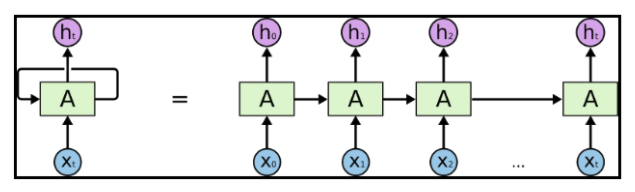

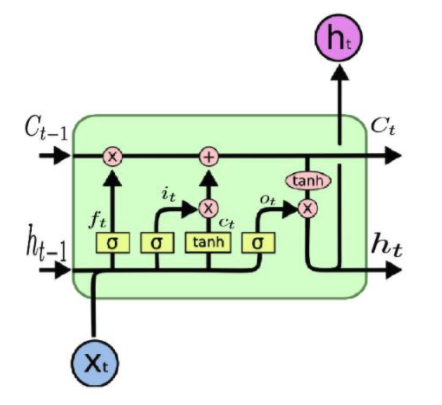

In [10]:
from collections import defaultdict

import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import random
import numpy as np

### Add Padding
- 학습하는 리뷰 문장의 길이(Sequence Length)를 맞추기 위해 padding을 추가

In [ ]:
def add_padding(token_list, max_len):
    pad = '<PAD>'
    seq_length_ls = []
    
    for i, tokens in enumerate(token_list):
        seq_length = len(tokens)
        
        # 문장이 짧은 경우
        if seq_length < max_len:
            seq_length_ls.append(seq_length)
            token_list[i] += [pad] * (max_len - seq_length)
        
        # 문장이 긴 경우
        elif seq_length >= max_len:
            seq_length_ls.append(max_len)
            token_list[i] = tokens[:max_len]
            
    return token_list, seq_length_ls

In [ ]:
X_train, x_train_seq_length = add_padding(X_train, max_sequence_length)
X_test, x_test_seq_length = add_padding(X_test, max_sequence_length)

In [ ]:
# Configuration
max_sequence_length = 30

### Convert token to index

- Vocab table을 만드는 작업
- 단어(토큰)에 index 번호를 부여해서 학습할때 사용
- 예시) "안녕" : 1 


In [ ]:
def convert_token_to_idx(token_list):
    for tokens in token_list:
        yield [token2idx[token] for token in tokens]
    return

In [ ]:
# key: token, value: index
token2idx = defaultdict(lambda: len(token2idx))
pad = token2idx['<PAD>']

X_train = list(convert_token_to_idx(X_train))
X_test = list(convert_token_to_idx(X_test))

# key: index, value: token
idx2token = {val : key for key, val in token2idx.items()}

### Packing

- Batch에서 가장 긴 문장이 맨 앞에 배치되도록 sorting하고 variable로 변환
- 참고 자료: https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html

In [ ]:
def sort_by_sequence_length(x, y, seq_len):
    sorted_idx = np.argsort(np.array(seq_len))[::-1]
    
    x = Variable(torch.LongTensor(np.array(x)[sorted_idx]))
    y = Variable(torch.LongTensor(np.array(y)[sorted_idx]))
    seq_len = Variable(torch.LongTensor(np.array(seq_len)[sorted_idx]))
    
    return x, y, seq_len

### Model Architecture

In [11]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text)) #embedded = [sent len, batch size, emb dim]
        
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        # unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        # hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [13]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

### Train Model

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,142,457 trainable parameters


In [15]:
import torch.optim as optim
# AdamW, AdamP
optimizer = optim.Adam(model.parameters())

In [16]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [17]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() # convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [18]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()

        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text, text_lengths = batch.text            
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path+'rnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 0.617 | Train Acc: 63.73%
	 Val. Loss: 0.526 |  Val. Acc: 72.25%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.529 | Train Acc: 71.72%
	 Val. Loss: 0.485 |  Val. Acc: 74.63%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.492 | Train Acc: 74.31%
	 Val. Loss: 0.481 |  Val. Acc: 75.65%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.470 | Train Acc: 75.71%
	 Val. Loss: 0.464 |  Val. Acc: 76.05%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 0.454 | Train Acc: 76.63%
	 Val. Loss: 0.460 |  Val. Acc: 76.49%


In [22]:
model.load_state_dict(torch.load(path+'rnn-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.462 | Test Acc: 76.37%


In [23]:
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = sentence.split(' ')
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [24]:
predict_sentiment(model, "영화 너무 재미없다!")

0.5543204545974731